In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
global singles
singles = '_singles.txt'

algo_info = {
    'silentwhispers':{
        'token':'SW-PER-MUL',
        'run_token':'SILENTW-false-true',
        'id':0
    },
    'speedymurmurs':{
        'token':'V-DYN',
        'run_token':'TDRAP-true-false',
        'id':7
    }
}
static_node_count = '67149'
static_data_root = 'data/static/READABLE_FILE_'
static_run_output = ''

def get_static_data_path(algo, tree, attempts):
    return f'{static_data_root}{algo_info[algo]["token"]}-{static_node_count}/0/CREDIT_NETWORK-STATIC-1000.0-TREE_ROUTE_{algo_info[algo]["run_token"]}-{tree}-2000.0-RANDOM_PARTITIONER-{attempts}'
    
def extract_kv_pairs_from_singles(singles_path):
    ret = {}
    with open(singles_path, 'r') as f:
        for line in f:
            k,v = line.rstrip().split('=')
            ret[k] = v
    return ret

def extract_from_singles(algo, attempts, trees, key):
    x_vs_key = []
    for tree in range(1,trees):
        data_path = get_static_data_path(algo, tree, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key

def extract_from_singles_attempts(algo, attempts, trees, key):
    x_vs_key = []
    for tree in range(1,attempts):
        data_path = get_static_data_path(algo, tree, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key


## Run a single static simulation

In [ ]:
import os

def run_static(transaction_set, algo, attempts, trees):
    os.system(f'java -cp {class_path} treeembedding.tests.Static {transaction_set} {algo} {attempts} {trees}')


## Figure 2 Plots

## 2a

### // TODO do runs
* first check if runs already exist

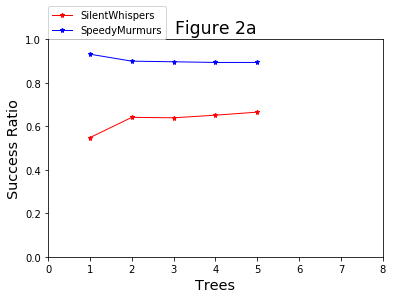

In [110]:
attempts = 1
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles("silentwhispers", attempts, 6, key)
speedymurmurs_data = extract_from_singles("speedymurmurs", attempts, 6, key)

f = plt.figure()
plt.title('Figure 2a', size='xx-large')
plt.ylabel('Success Ratio', size='x-large')
plt.xlabel('Trees', size='x-large')
plt.axis([0,8,0.0,1.0])

plt.plot(range(1,6), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,6), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)



## 2b

### // TODO do runs
* first check if runs already exist

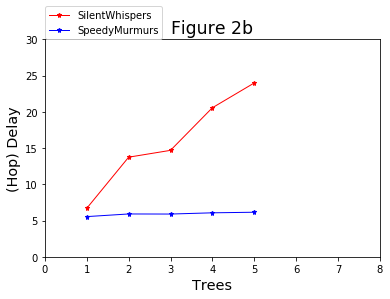

In [113]:
attempts = 1
key = 'CREDIT_NETWORK_DELAY_AV'
silentwhispers_data = extract_from_singles("silentwhispers", attempts, 6, key)
speedymurmurs_data = extract_from_singles("speedymurmurs", attempts, 6, key)

f = plt.figure()
plt.title('Figure 2b', size='xx-large')
plt.ylabel('(Hop) Delay', size='x-large')
plt.xlabel('Trees', size='x-large')
plt.axis([0,8,0,30])

plt.plot(range(1,6), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,6), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)

## 2c

### // TODO do runs
* first check if runs already exist

In [117]:
attempts = 10
trees = 3
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles_attempts("silentwhispers", attempts, trees, key)
speedymurmurs_data = extract_from_singles_attempts("speedymurmurs", attempts, trees, key)

f = plt.figure()
plt.title('Figure 2c', size='xx-large')
plt.ylabel('Success Ratio', size='x-large')
plt.xlabel('Attempts', size='x-large')
plt.axis([0,10,0.0,1.0])

plt.plot(range(1,10), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
plt.plot(range(1,10), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
plt.legend(loc=(0,1), scatterpoints=10)

FileNotFoundError: [Errno 2] No such file or directory: 'data/static/READABLE_FILE_SW-PER-MUL-67149/0/CREDIT_NETWORK-STATIC-1000.0-TREE_ROUTE_SILENTW-false-true-1-2000.0-RANDOM_PARTITIONER-10/_singles.txt'